# 2D Neural Style Transfer - Style Feature Decomposition in BN Statistics.

This is the Jupyter Notebook for 2D neural style transfer which only applies style loss based on batch normalization statistics and allows operations on those statistics in each layer. This gives hints on how to achieve style feature decomposition.

In detail, one can do affine transformation (x --> x * a + b) and FFT filtering on those statistics. It is recommended to focus more on stds than means, since operations on stds yield more interesting style reconstructions.

This notebook can be directly run on Google Colab without additional effort. For acceleration it is helpful to use a GPU runtime.

## Step 0: imports

In [1]:
import sys
import torch
import matplotlib.pyplot as plt

# install KeOps kernels
!pip install -q pykeops==1.4.1 # > install.log

# install pytorch version of np.Interp, which is used for histogram loss
!pip install -q git+https://github.com/aliutkus/torchinterp1d.git

# Please run the following two lines DEPENDENTLY! (depends on whether the notebook is run locally or on Colab)
!git clone https://github.com/wmd0701/MA.git NST
%cd NST

# import self-defined functions
from utils.data_loader import image_loader, image_unloader
from utils.pipeline import pipeline_2D_NST_OpsOnBNST
from utils.plot import plot_statistics, plot_spectrum

# better plot
%pylab inline

     |████████████████████████████████| 319 kB 16.8 MB/s 
Cloning into 'NST'...
remote: Enumerating objects: 417, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 417 (delta 21), reused 35 (delta 20), pack-reused 380
Receiving objects: 100% (417/417), 84.75 MiB | 22.12 MiB/s, done.
Resolving deltas: 100% (240/240), done.
/content/NST
PyTorch3D not installed! Ignore this message if running 2D NST.
PyTorch3D not installed! Ignore this message if running 2D NST.
PyTorch3D not installed! Ignore this message if running 2D NST.
Populating the interactive namespace from numpy and matplotlib


## Step 1: set up configs

For affine transformation x --> x * coef + bias, one can set **mean_coef**, **mean_bias**, **std_coef** and **std_bias**. They can be either a single float value, or a list of float values. In case a list is given, the length of this list should be equal to the length of **style_layers**, as each element in the list is applied to a corresponding layer in **style_layers**.

For FFT filtering, one should control **mean_freq** and **std_freq**. These two arguments are list of list of tuple. The first level list has length equal to the length of **style_layers**, as each element in the list is applied to a corresponding layer. Each element in the list is also a list, which consists of (float, float) tuples that specify desired frequency range. Consider the following example: three layer are used for style transfer, and for BN stds in the second layer we only want components with freq <= 0.05 or 0.1 <= freq <= 0.3 or freq > 0.4. In such a case, **std_freq** should be [ [(None, None)], [(None, 0.05), (0.1, 0.3), (0.4, None)], [(None, None)] ].

PS: FFT generates spectrum in frequency range [0, 0.5] and interpolates according to data length. In such a case, if you want DC components (freq = 0), you can apply low pass filter with a very low frequency threshold (e.g. 0 or 1e-10). Similarly, for rest components (freq > 0), just apply high pass filter with frequency threshold 1e-10.

In [2]:
# common settings for all configs
style_layers = ['conv1_1', 'conv3_1', 'conv4_1']
style_weights = [1e6/n**2 for n in [64,256,512]]
model_pooling = 'max'
n_iters = 200
learning_rate = 1

# configs
configs = [# config 0
           {'image_path':'starry_night.jpg', 'imsize':256, 'tiling':1, 'indices':None,
            'mean_coef':1, 'mean_bias':0, 'std_coef':1, 'std_bias':0, 
            'mean_freq': [ [(None, None)], [(None, None)], [(None, None)] ], 
            'std_freq':  [ [(None, None)], [(None, None)], [(None, None)] ]
            },
           
           # config 1
           {'image_path':'starry_night.jpg', 'imsize':256, 'tiling':1, 'indices':None,
            'mean_coef':1, 'mean_bias':0, 'std_coef':1, 'std_bias':0, 
            'mean_freq': [ [(None, None)], [(None, None)], [(None, None)] ],
            'std_freq':  [ [(None, None)], [(None, None)], [(1e-10, None)] ]
            },
           
           # config 2
           {'image_path':'starry_night.jpg', 'imsize':256, 'tiling':1, 'indices':None,
            'mean_coef':1, 'mean_bias':0, 'std_coef':1, 'std_bias':0, 
            'mean_freq': [ [(None, None)], [(None, None)], [(None, None)] ],
            'std_freq':  [ [(None, None)], [(None, None)], [(None, 1e-10)] ]
            },
           
           ]

## Step 2: run neural style transfer pipeline

In [3]:
# lists of BN means / stds and output images
means = {config_idx : {} for config_idx in range(len(configs))}
stds  = {config_idx : {} for config_idx in range(len(configs))}
output_imgs = []

config_idx = 0
for config in configs:
    # read params from config
    image_path = config.get('image_path', 'starry_night.jpg')
    imsize = config.get('imsize', None)
    tiling = config.get('tiling', 1)
    indices = config.get('indices', None)
    mean_coef = config.get('mean_coef', 1)
    mean_bias = config.get('mean_bias', 0)
    std_coef = config.get('std_coef', 1)
    std_bias = config.get('std_bias', 0)
    mean_freq = config['mean_freq'] # config.get('mean_freq', None)
    std_freq  = config['std_freq'] # config.get('std_freq', None)
 
    # images
    style_img = image_loader("./image_style/"+image_path, imsize=imsize, tiling=tiling)
    input_img = torch.rand((1,3,256,256), device=style_img.device)

    # pipeline
    output_img, loss_history, style_losses = pipeline_2D_NST_OpsOnBNST( style_img = style_img, 
                                                                        input_img = input_img,
                                                                        n_iters = n_iters,
                                                                        style_weights = style_weights,
                                                                        style_layers = style_layers,
                                                                        learning_rate = learning_rate,
                                                                        model_pooling = model_pooling,
                                                                        silent = True,
                                                                        indices = indices,
                                                                        mean_coef=mean_coef, mean_bias=mean_bias,
                                                                        std_coef=std_coef, std_bias=std_bias, 
                                                                        mean_freq=mean_freq, std_freq=std_freq
                                                                        )

    # add output image
    output_imgs.append(image_unloader(output_img))                          

    # add statistics
    for style_layer_idx in range(len(style_layers)):
        style_layer_str = style_layers[style_layer_idx]
        means[config_idx][style_layer_str] = style_losses[style_layer_idx].target_mean_filtered.detach().cpu()
        stds[config_idx] [style_layer_str] = style_losses[style_layer_idx].target_std_filtered.detach().cpu()
    
    config_idx += 1

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

run [20]:
run [40]:
run [60]:
run [80]:
run [100]:
run [120]:
run [140]:
run [160]:
run [180]:
run [200]:
run [220]:
run [20]:
run [40]:
run [60]:
run [80]:
run [100]:
run [120]:
run [140]:
run [160]:
run [180]:
run [200]:
run [220]:
run [20]:
run [40]:
run [60]:
run [80]:
run [100]:
run [120]:
run [140]:
run [160]:
run [180]:
run [200]:
run [220]:


## Step 3: plots

### plot style reconstructions

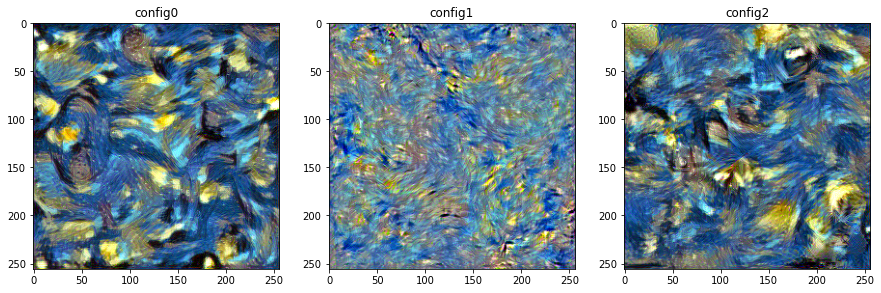

In [4]:
plt.figure(figsize=(5*len(output_imgs), 5))
for i in range(len(output_imgs)):
    plt.subplot(1, len(output_imgs), i+1)
    plt.imshow(output_imgs[i])
    plt.title('config' + str(i))

### plot BN mean / std

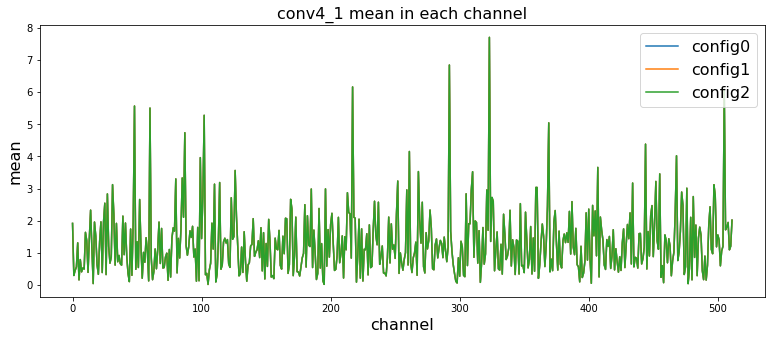

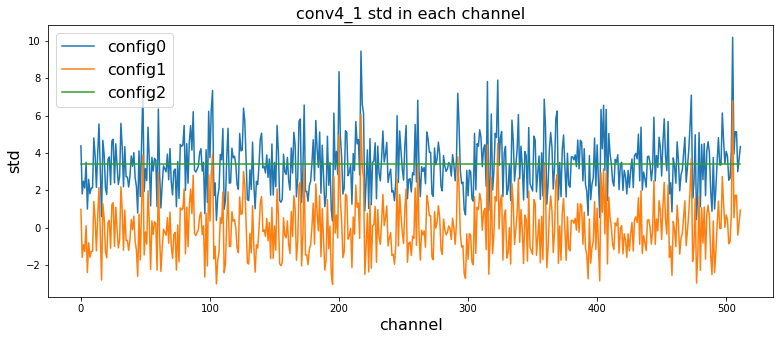

In [5]:
plot_statistics(means, config_idx = None, style_layer = 'conv4_1', title = 'mean')
plot_statistics(stds,  config_idx = None, style_layer = 'conv4_1', title = 'std')

### plot spectrums

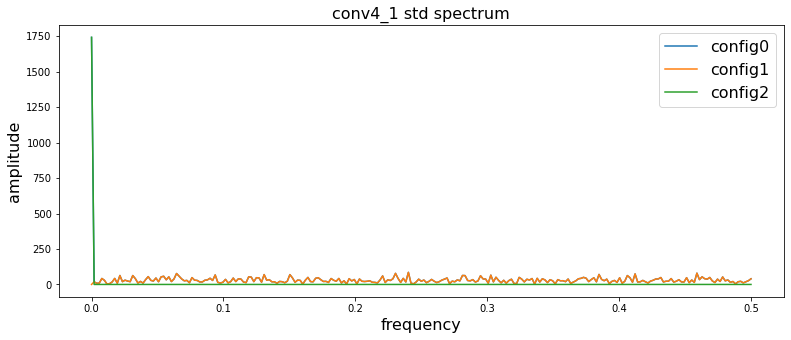

In [6]:
plot_spectrum(stds,  config_idx = None, style_layer = 'conv4_1', title = 'std')